# Projeto 3 - Treinando Pacman com Modelo Evolucionário e Aprendizado por Reforço

Aluno: André Soranzzo Mota RA: 166404

Aluna: Rebecca Moreira Messias RA: 186416

*Participação*: O trabalho foi feito em Pair Programming

## Objetivos

O objetivo desse trabalho é fazer com o Pacman aprenda a ganhar partidas de seu jogo. Para realizar tal feito, iremos abordar duas metodologias. Na primeira metodologia será abordado o conceito de Modelo Evolucionário utilizando Algoritmo Genético e a segunda metodologia é implementada com base no Aprendizado por Reforço. 

## Evolucionary Model

### Introdução
Para essa parte do projeto escolhemos o Algoritmo Genético. Os parâmetors que realizamos variação são taxa de crossover, taxa de mutação, critério de parada e tamanho da população.

### Função de avaliação
A função de avaliação do individuo fazemos uma combinação da pontuação máxima com bonificação caso o Pacman vença os mapas.

### Função de crossover
Para realizar o crossover utilizamos a técnica de ponto único.

### Seleção dos indivíduos
A seleção dos indivíduos para mutação e crossover é feita aleatoriamente. Dessa forma,  garantimos que não tenha valores negativos na nossa função de avaliação aplicando uma máscara com o valor mínimo do vetor.

### Pacman
Foi criado um agente chamado "GeneticAgent" em "pacmanAgents.py", que decide o caminho que vai seguir de acordo com a lista de moviemntos passada por parâmetro. Se não for possível realizar tal movimento, o Pacaman segue em frente e se essa opção também não for possível o Pacman retorna o caminho. Um individuo é composto de uma série de genes que podem ter o valor 'L' ou 'R' (direções que o Pacaman poderá seguir, onde L é esquerda e R é direita). A quantidade de genes que um indivíduo tem é determinada por um parâmetro quando chamamamos a função de criação da população. As gerações evoluem até atingir a quantidade máxima de geração definida ou a diferença percentual entre uma média de população e sua anterior menor que 1%.

### Implementação

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

In [2]:
random.seed(10)
mapas = ['smallClassic', 'mediumClassic', 'originalClassic']

A função abaixo irá iniciar nossa população com tamanho de acordo com o que for informado na variável `tamanhoPopulacao` passado por parâmetro. Essa função irá retornar a população criada.

In [3]:
def inicializa_populacao(tamanhoPopulacao, minimoCaracteres, maximoCaracteres):
    populacao = []
    for i in range(tamanhoPopulacao):
        len  = random.randint(minimoCaracteres, maximoCaracteres)
        individuo = ""
        for c in range(len):
            caracteres = random.randint(1, 100)
            if caracteres >= 50:
                individuo = individuo + 'L'
            else:
                individuo = individuo + 'R'
        populacao.append(individuo)
    populacao = np.array(populacao)
    return populacao

A função abaixo realiza o crossover de dois indivíduos. Ela pega um ponto dos pais e cria novos dois a partir da intercalação dos genes dos pais. O retorno da função é dois indivíduos filhos.

In [4]:
def crossover(individuo1, individuo2):
    individuo1 = list(individuo1)
    individuo2 = list(individuo2)

    tamanhoIndividuo1 = len(individuo1)
    tamanhoIndividuo2 = len(individuo2)
    tamanho = 0
    tamanho = min(tamanhoIndividuo1, tamanhoIndividuo2)
    k = random.randint(0, tamanho - 1)
  
    for i in range(0, k):
        individuo1[i], individuo2[i] = individuo2[i], individuo1[i]
    
    individuo1 = ''.join(individuo1)
    individuo2 = ''.join(individuo2)
    
    return individuo1, individuo2

A função abaixo realiza a mutação em um indivíduo. Ela altera 1 gene do indivíduo. O retorno dessa função é o indivíduo mutante.

In [5]:
def mutacao(individuo):
    individuo = list(individuo)
    
    gene = random.randint(0, len(individuo) - 1)
    
    if individuo[gene] == 'L':
        individuo[gene] = 'R'
    else:
        individuo[gene] = 'L'
    
    individuo = ''.join(individuo)
    return individuo

A função abaixo seleciona um ou dois indivíduos da população de acordo com suas avaliações. A função retorna os indivíduos escolhidos.

In [6]:
def selecao(individuos, avaliacoes):
    individuo = []

    valorMinimo = np.min(avaliacoes)
   
    if valorMinimo < 0:
        avaliacoes = avaliacoes - valorMinimo

    avaliacoes = np.sqrt(avaliacoes + 1)

    valorMaximo = np.sum(avaliacoes)
    
    for n in range(individuos):
        escolhido = random.uniform(0, valorMaximo)
        atual = 0
    
        for i in range(len(avaliacoes)):
            atual += avaliacoes[i]
            
            if atual > escolhido:
                individuo.append(i)
                break
    
    return individuo

A função abaixo cria uma nova geração. Ela recebe a população pai e cria os novos filhos. O retorno dessa função é a nova população.

In [7]:
def criaNovaGeracao(populacao, taxaEstabilidade, taxaMutacao, taxaCrossover, avaliacoes):
    novaPopulacao = []
    avaliacoesAux = avaliacoes.copy()
    populacaoAux = populacao.copy()

    for i in range(int(taxaEstabilidade * len(populacao))):
        if populacao[np.argmax(avaliacoes)] not in novaPopulacao:
            novaPopulacao.append(populacao[np.argmax(avaliacoes)])
        else:
            i = i - 1 
        
        avaliacoes = np.delete(avaliacoes, np.argmax(avaliacoes))
        populacao = np.delete(populacao, np.argmax(avaliacoes))
        
    
    populacao = populacaoAux
    avaliacoes = avaliacoesAux

    for i in range(int(taxaCrossover * len(populacao) / 2)):
        individuo = selecao(2, avaliacoes)
        a, b = crossover(populacao[individuo[0]], populacao[individuo[1]])
        novaPopulacao.append(a)
        novaPopulacao.append(b)
    
    for i in range(int(taxaMutacao * len(populacao))):
        individuo = selecao(1, avaliacoes)
        novaPopulacao.append(mutacao(populacao[individuo[0]]))
    
    novaPopulacao = np.array(novaPopulacao)
    
    return novaPopulacao

A função abaixo faz a avaliação da população. É onde inicializamos a partida e faz com que cada indivíduo da população jogue em cada mapa. Essa função retorna as métricas das partidas jogadas pelos indivíduos.

In [8]:
def jogaPacman(populacao, mapas):
    mediaPopulacoes= []
    vitoriaPopulacoes = []

    for i in populacao:
        pontuacoes = []
        vitorias = []
        
        for mapa in mapas:
            resultado = !python pacman.py -p GeneticAgent -a steps=$i -l $mapa -q -f
            vencedor = int(resultado[3].split(':')[1].split('/')[0].replace(" ", ""))
            vitorias.append(vencedor)
            pontuacao = float(resultado[1].split(':')[1].replace(" ", ""))
            pontuacoes.append(pontuacao)

        mediaIndividual = np.mean(pontuacoes)
        mediaPopulacoes = mediaPopulacoes + [mediaIndividual]
        vitoriasGeral = np.sum(vitorias)
        vitoriaPopulacoes.append(vitoriasGeral)
        
    mediaPopulacoes = np.array(mediaPopulacoes)
    vitoriaPopulacoes = np.array(vitoriaPopulacoes)
    
    return mediaPopulacoes, vitoriaPopulacoes

A função abaixo verifica se ainda o modelo deve continuar treinando pelas médias.

In [9]:
def verificaCriterioParadaPelaMedia(geracaoAtual, geracaoAnterior):
    diferenca = geracaoAtual - geracaoAnterior
    razao = diferenca/geracaoAtual
    
    if razao < 0:
        razao = razao * -1
    
    if razao < 0.005:
        return True
    
    return False

A função abaixo verifica se ainda o modelo deve continuar treinando pelas vitórias.

In [10]:
def verificaCriterioParadaPelaVitoria(geracaoAtual, geracaoAnterior):
    status = False
    
    if geracaoAtual >= geracaoAnterior:
        status = True
    
    return status

A função abaixo é a função de treinamento do nosso modelo.

In [11]:
def treinamento(populacao, mapas, maximoGeracoes, taxaEstabilidade, taxaMutacao, taxaCrossover):
    metricas = []
    metricas.append(["Geração", "Média da Geração", "Taxa de vitória", "Valor máximo", "Valor mínimo"])
    tabelaMetricas = pd.DataFrame()
    
    geracoes = []
    geracoes.append(populacao)

    mediaGeracao = []
    maximoValoresGeracao = []
    individuoMaximoGeracao = []
    minimoValoresGeracao = []
    taxaVitoriaGeracao = []

    parada = False

    
    for g in range(maximoGeracoes):
        medias, vitorias = jogaPacman(geracoes[g], mapas)

        maximoValoresGeracao.append(np.amax(medias))
        max_ind_idx = np.where(medias == maximoValoresGeracao[g])
        individuoMaximoGeracao.append(geracoes[g][max_ind_idx[0]])
        minimoValoresGeracao.append(np.amin(medias))
        mediaGeracao.append(np.mean(medias))
        totalVitorias = np.sum(vitorias)
        totalJogos = (len(mapas)*populacao.shape[0])
        taxaVitoriaGeracao.append(totalVitorias/totalJogos)
        
        np.append(metricas, [g, mediaGeracao[g], taxaVitoriaGeracao[g], maximoValoresGeracao[g], minimoValoresGeracao[g]])
        metricas = np.array(metricas)
        
        tabelaMetricas = pd.DataFrame(metricas)
        
        if g > 0:
            parada = verificaCriterioParadaPelaMedia(mediaGeracao[g], mediaGeracao[g-1]) and verificaCriterioParadaPelaVitoria(taxaVitoriaGeracao[g], taxaVitoriaGeracao[g-1])
        
        if parada:
            break

        proximaGeracao = criaNovaGeracao(geracoes[g], taxaEstabilidade, taxaMutacao, taxaCrossover, medias)
        geracoes.append(proximaGeracao)
    
    tabelaMetricas.head()
    
    return geracoes, mediaGeracao, maximoValoresGeracao, minimoValoresGeracao, taxaVitoriaGeracao, individuoMaximoGeracao

In [12]:
tamanhoPopulacao = 50
maximoGeracao = 500
taxaEstabilidade = 0.2
taxaMutacao = 0.2
taxaCrossover = 0.7
minimoCaracteres = 3
maximoCaracteres = 40
populacao1 = inicializa_populacao(tamanhoPopulacao, minimoCaracteres, maximoCaracteres)

In [13]:
geracoes, mediaGeracoes, valoresMaximoGeracoes, valoresMinimoGeracoes, taxaVitoriaGeracao, individuoMaximoGeracao = treinamento(populacao1, mapas, maximoGeracao, taxaEstabilidade, taxaMutacao, taxaCrossover)

In [20]:
tamanhoPopulacao = 25
maximoGeracao = 500
taxaEstabilidade = 0.05
taxaMutacao = 0.15
taxaCrossover = 0.8
minimoCaracteres = 10
maximoCaracteres = 35
populacao2 = inicializa_populacao(tamanhoPopulacao, minimoCaracteres, maximoCaracteres)

In [21]:
geracoes2, mediaGeracoes2, valoresMaximoGeracoes2, valoresMinimoGeracoes2, taxaVitoriaGeracao2, individuoMaximoGeracao2 = treinamento(populacao2, mapas, maximoGeracao, taxaEstabilidade, taxaMutacao, taxaCrossover)

### Gráficos dos treinos obtidos acima

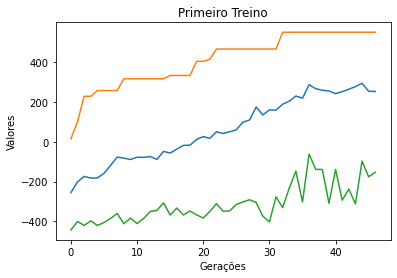

In [34]:
plt.title('Primeiro Treino')

plt.plot(mediaGeracoes, label = "Média")
plt.plot(valoresMaximoGeracoes, label = "Máximo")
plt.plot(valoresMinimoGeracoes, label = "Mínimo")

plt.xlabel('Gerações')
plt.ylabel('Valores')

plt.show()

In [35]:
individuoMaximoGeracao[46][0]

'RLRLRRLRLLRLLRRRLRRLLLRLRL'

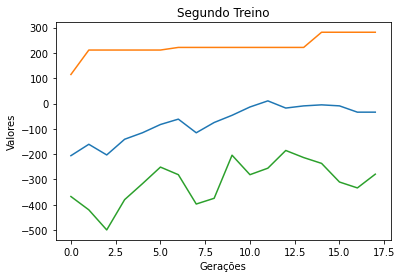

In [36]:
plt.title('Segundo Treino')

plt.plot(mediaGeracoes2, label = "Média")
plt.plot(valoresMaximoGeracoes2, label = "Máximo")
plt.plot(valoresMinimoGeracoes2, label = "Mínimo")

plt.xlabel('Gerações')
plt.ylabel('Valores')

plt.show()

In [37]:
individuoMaximoGeracao2[17][0]

'RLRLLRLRRLLRRLRRLRRLLRRLLLLLL'

In [38]:
individuoMaximoGeracao[46]

array(['RLRLRRLRLLRLLRRRLRRLLLRLRL', 'RLRLRRLRLLRLLRRRLRRLLLRLRL',
       'RLRLRRLRLLRLLRRRLRRLLLRLRL', 'RLRLRRLRLLRLLRRRLRRLLLRLRL'],
      dtype='<U26')

### Conclusões do genetic algorithm desenvolvido
Foi dificultoso criar um indivíduo genérico para os 3 mapas, pois cada mapa possui caminhos e características específicas. Por conta disso, muitas vezes o pacman seguia caminhos que não recompensavam bem por não considerar a melhor pontuação para decidir seu próximo caminho. Além disso, um agente que iria muito bem em um mapa, poderia ficar em um loop em outro mapa tomando os mesmos conjuntos de ações, desse modo ele apenas esperava sua morte por um fantasma em um dos mapas, mesmo indo extremamente bem em outro. No desenvolvimento de nosso pacman também não consideramos a posição dos fantasmase e por conta disso nosso pacman não fugia deles. Com isso, alguns indivíduos seguiam de encontro com fantasmas, mesmo não tendo consumido o poder, o que pode nos dar baixa probabilidade de sobrevivência.
Nos nossos primeiros testes havia um grande número de repetições de indivíduos em uma população. Nesses testes até conseguimos um bom resultado, mas isso não significou uma boa população. Nossos testes acabaram levando para um máximo local, em que um indivíduo ganhava ou adquiria muitos pontos em um mapa, mas não tinha sucesso nos outros.